# **Section:** Features evaluation

In [1]:
import os
import itertools as it
import warnings

import numpy as np

import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

import joblib

import pathlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import DataConversionWarning

import tqdm

from libs.container import Container
from libs.nearest import nearest
from libs.experiment import WithAnotherExperiment, roc, metrics
from libs.precstar import  prec_star

warnings.simplefilter("ignore", category=DataConversionWarning)

/home/jbcabral/miniconda2/envs/howfar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
PATH = pathlib.Path(os.path.abspath(os.path.dirname("")))

DATA_PATH = PATH / "_data"

COLUMNS_NO_FEATURES = ['id', 'tile', 'cnt', 'ra_k', 'dec_k', 'vs_type', 'vs_catalog', 'cls'] 

In [3]:
sample = pd.read_pickle("_data/s5k_scaled.pkl.bz2")

# the features
X_columns = [c for c in sample.columns if c not in COLUMNS_NO_FEATURES]
y_column = "cls"

sample[X_columns] =  sample[X_columns].astype(np.float32)

data = Container({k: v for k, v in sample.groupby("tile") if k in ["b234", "b360", "b278", "b261"]})

del sample

In [4]:
data

<Container({'b234': 5126, 'b261': 5252, 'b278': 5435, 'b360': 5669})>

In [5]:
def make_clf(k, df, X_columns):    
    X_train = df[X_columns].values
    y_train = df.cls.values

    clf = RandomForestClassifier(n_estimators=500, criterion="entropy")
    clf.fit(X_train, y_train)
    return k, clf


def get_clfs(data, X_columns):
    print("Creating classifiers with {} features...".format(len(X_columns)))
    with joblib.Parallel(n_jobs=-1) as jobs:
        clfs = jobs(
            joblib.delayed(make_clf)(k, d, X_columns)
            for k, d in sorted(tqdm.tqdm(data.items())))
    return Container(clfs)

def get_combs(data, X_columns):
    combs = []
    clfs = get_clfs(data, X_columns)
    for train_name, clf in clfs.items():
        for test_name in clfs.keys():
            if train_name != test_name:
                test_sample = data[test_name]
                comb = Container({
                    "idx": len(combs), 
                    "train_name": train_name, "clf": clf,  
                    "test_name": test_name, "test_sample": test_sample,
                    "X_columns": X_columns, "y_column": y_column})
                combs.append(comb)
    return combs

def execute_clf(idx, train_name, clf, test_name, test_sample, X_columns, y_column):
    
    X_test = test_sample[X_columns].values
    y_test = test_sample[y_column].values
    
    predictions = clf.predict(X_test)
    probabilities = clf.predict_proba(X_test)
    
    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, 1.-probabilities[:,0], pos_label=1)

    prec_rec_curve = metrics.precision_recall_curve(
        y_test, 1.- probabilities[:,0], pos_label=1)

    roc_auc = metrics.auc(fpr, tpr)
    
    result = Container({
        "idx": idx,
        "train_name": train_name,
        "test_name": test_name,
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'real_cls': y_test,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_test, predictions)})    
    return result

def train_and_run(data, X_columns):
    combs = get_combs(data, X_columns)
    print("Combinaciones: {}".format(len(combs)))
    
    print("Launching classifiers for {} features...".format(len(X_columns)))
    with joblib.Parallel(n_jobs=-1) as jobs:
        results = jobs(
            joblib.delayed(execute_clf)(**comb) for comb in tqdm.tqdm(combs))
    return results

In [6]:
%%time
all_features_results = train_and_run(data, X_columns)

100%|██████████| 4/4 [00:00<00:00, 15505.74it/s]

Creating classifiers with 64 features...



100%|██████████| 12/12 [00:00<00:00, 16373.34it/s]

Combinaciones: 12
Launching classifiers for 64 features...


CPU times: user 4.05 s, sys: 350 ms, total: 4.4 s
Wall time: 39.2 s


## Fetures based on periods

In [7]:
period_X_columns = [c for c in X_columns if c.startswith("Freq") or c in ["PeriodLS", "Period_fit", "ppmb", "Psi_CS", "Psi_eta"]]
no_period_X_columns = [c for c in X_columns if c not in period_X_columns]

In [8]:
%%time
period_results = train_and_run(data, period_X_columns)

100%|██████████| 4/4 [00:00<00:00, 17660.23it/s]

Creating classifiers with 26 features...



100%|██████████| 12/12 [00:00<00:00, 16469.78it/s]

Combinaciones: 12
Launching classifiers for 26 features...


CPU times: user 3.77 s, sys: 139 ms, total: 3.91 s
Wall time: 32.5 s


In [9]:
%%time
no_period_results = train_and_run(data, no_period_X_columns)

100%|██████████| 4/4 [00:00<00:00, 15128.24it/s]

Creating classifiers with 38 features...



100%|██████████| 12/12 [00:00<00:00, 17302.04it/s]

Combinaciones: 12
Launching classifiers for 38 features...


CPU times: user 3.93 s, sys: 112 ms, total: 4.04 s
Wall time: 27.1 s


## Fetures based on extintion

In [10]:
extintion_X_columns = [c for c in X_columns if c.startswith("n09_") or c.startswith("c89_")]
no_extintion_X_columns = [c for c in X_columns if c not in extintion_X_columns]

In [11]:
%%time
extintion_results = train_and_run(data, extintion_X_columns)

100%|██████████| 4/4 [00:00<00:00, 7887.74it/s]

Creating classifiers with 12 features...



100%|██████████| 12/12 [00:00<00:00, 13950.01it/s]

Combinaciones: 12
Launching classifiers for 12 features...


CPU times: user 3.86 s, sys: 146 ms, total: 4.01 s
Wall time: 20.4 s


In [12]:
%%time
no_extintion_results = train_and_run(data, no_extintion_X_columns)

100%|██████████| 4/4 [00:00<00:00, 9788.34it/s]

Creating classifiers with 52 features...



100%|██████████| 12/12 [00:00<00:00, 12592.36it/s]

Combinaciones: 12
Launching classifiers for 52 features...


CPU times: user 3.83 s, sys: 116 ms, total: 3.95 s
Wall time: 36.3 s


## Analysis

In [13]:
all_results = {
    "All Features": all_features_results,
    "Period Based": period_results,
    "Period Independent": no_period_results,
    "Extintion Based": extintion_results,
    "Extintion Independent": no_extintion_results}

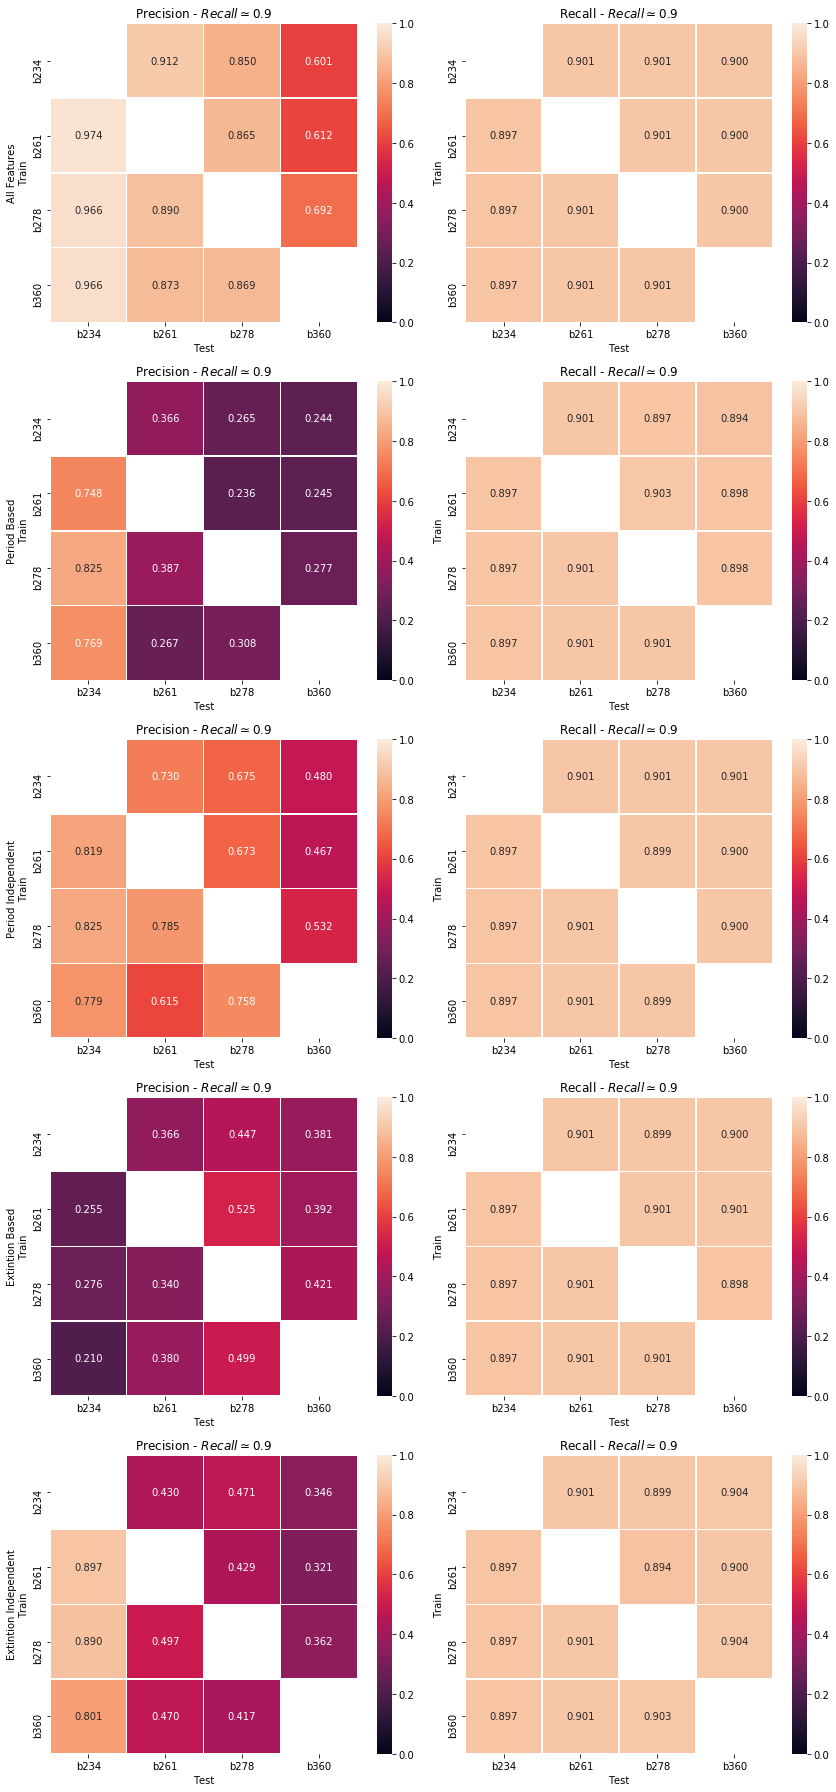

In [14]:
def as_df(data):
    rows, tiles = [], sorted(list(data.keys()))
    for rname in tiles:
        row = data[rname].copy()
        row.update({"Train": rname}) 
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df.set_index("Train")[tiles]
    return df

def heatmap(ax, results, fp):
    cmap = sns.cm.rocket
    
    fix_recall, fix_precs = {}, {}
    for r in results:
        train_name, test_name = r["train_name"], r["test_name"]
        
        if train_name not in fix_recall:
            fix_recall[train_name] = {}
            fix_precs[train_name] = {}
            
        precs, recalls, probs = r.prec_rec_curve
        
        idx = nearest(recalls, fp)
        
        fix_recall[train_name][test_name] = recalls[idx]
        fix_precs[train_name][test_name] = precs[idx]
        
    fix_precs = as_df(fix_precs)
    fix_recall = as_df(fix_recall)
    
    sns.heatmap(fix_precs, annot=True, fmt='.3f',  linewidths=.5, ax=ax[0], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[0].set_xlabel("Test")
    ax[0].set_title(u"Precision - $Recall\simeq{}$".format(fp))
    
    sns.heatmap(fix_recall, annot=True, fmt='.3f', linewidths=.5, ax=ax[1], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[1].set_xlabel("Test")
    ax[1].set_title(u"Recall - $Recall\simeq{}$".format(fp))

fig, axes = plt.subplots(5, 2, figsize=(12, 5*5))

for rname, axs in zip(all_results, axes):
    heatmap(axs, all_results[rname], 0.90)
    axs[0].set_ylabel(f"{rname}\n{axs[0].get_ylabel()}")
    
fig.tight_layout()
fig.savefig("plots/section_features_prec_rec_heatmap.pdf")

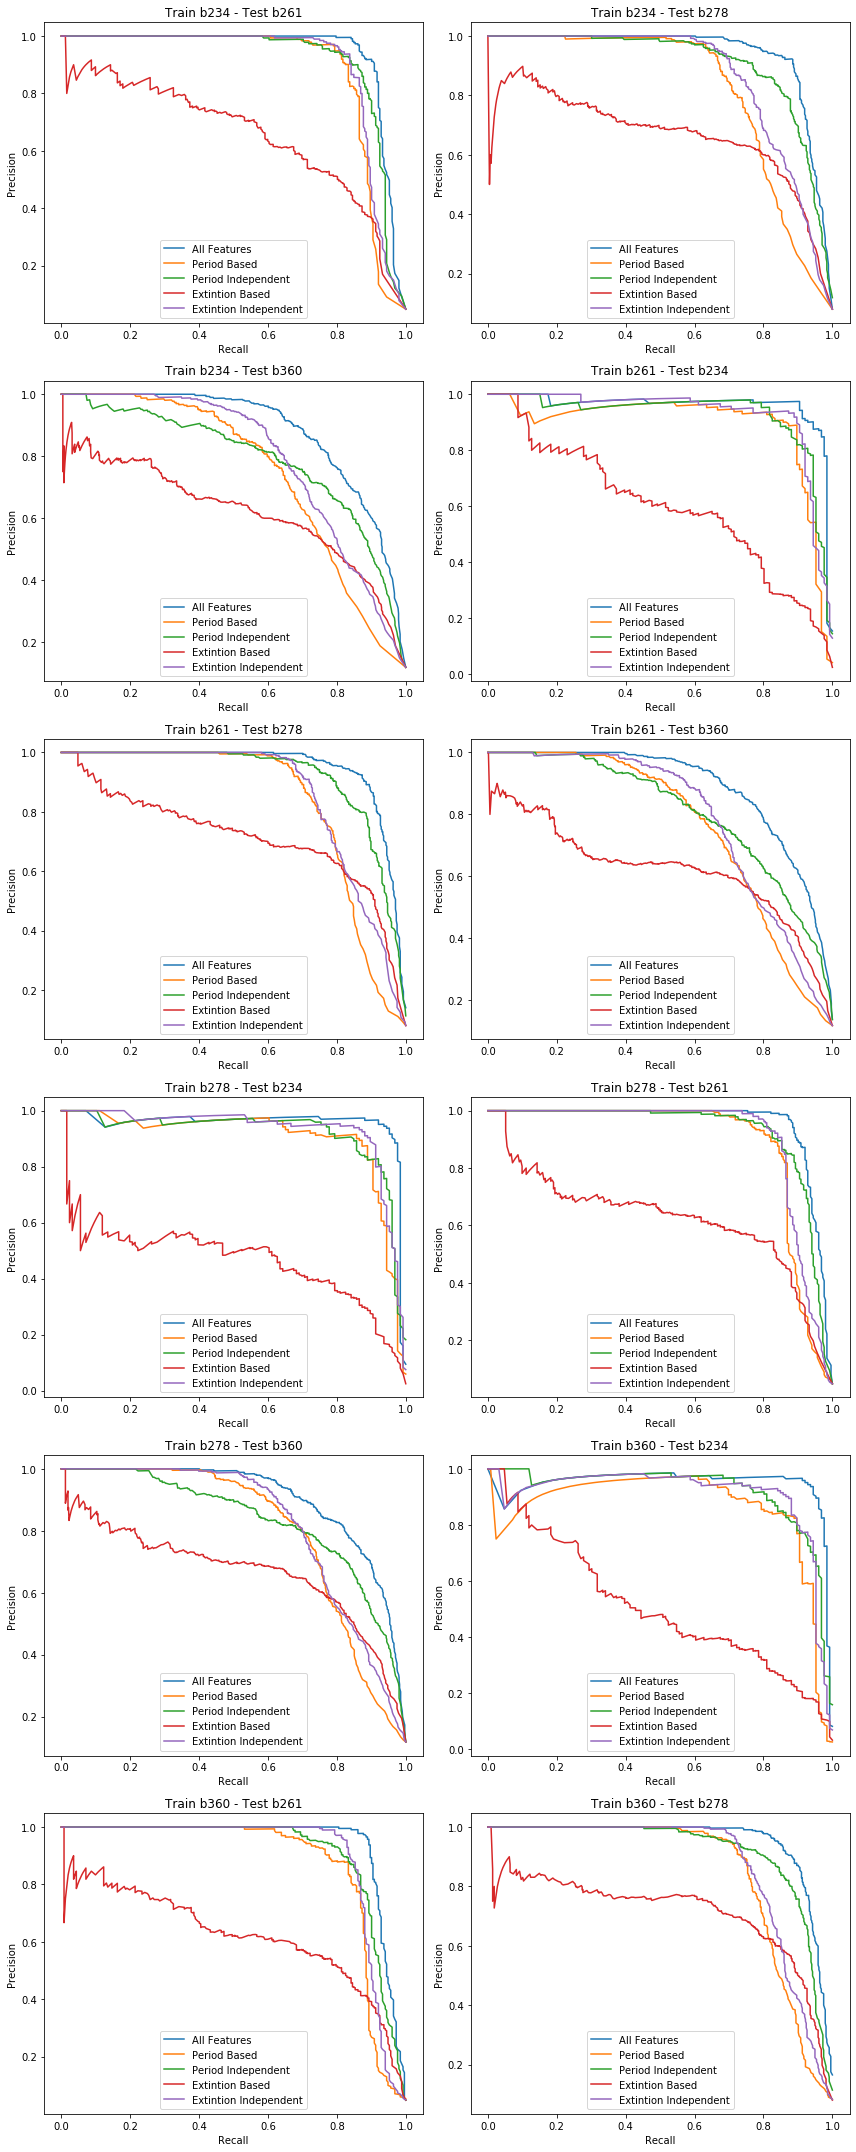

In [15]:
def plot_prec_roc_curve(ax, train_name, test_name, all_results):
    for rname, results in all_results.items():
        for r in results:
            if r.test_name == test_name and r.train_name == train_name:
                ax.plot(r.prec_rec_curve[1], r.prec_rec_curve[0], label=rname)
                break
    ax.set_title("Train {} - Test {}".format(train_name, test_name))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend(loc='lower center')

fig, axes = plt.subplots(6, 2, figsize=(12, 30))
axes = it.chain(*axes)
for train_name in data.keys():
    for test_name in data.keys():
        if train_name == test_name:
            continue
        ax = next(axes)
        plot_prec_roc_curve(ax, train_name, test_name, all_results)
fig.tight_layout()
fig.savefig("plots/section_features_prec_rec_curve.pdf")